This is the notebook used to perform kmeans on organ data to generate label like images for lab2im generation

In [26]:
import nibabel as nib
import numpy as np 
from sklearn.cluster import KMeans

def main():
    scan = nib.load('/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10010.FatImaging_W.nii.gz')
    segmentation_mask = nib.load('/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10010.FatImaging_W.nii.gz')

    # get the data 
    mri_data = scan.get_fdata()
    mask_data = segmentation_mask.get_fdata()

    # get anomaly indices
    anomaly_indices = np.where(mask_data == 1)

    anomaly_values = mri_data[anomaly_indices]
    average_value = np.mean(anomaly_values)

    mri_data[anomaly_indices] = average_value

    modified_scan = nib.Nifti1Image(mri_data, scan.affine)

    mri_data = modified_scan.get_fdata()
    mri_data_flattened = mri_data.reshape(-1, 1)

    # Define the number of clusters for k-means
    n_clusters = 30  # Adjust as needed

    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Fit the model to the flattened data
    kmeans.fit(mri_data_flattened)

    # Get cluster labels for each pixel in the flattened data
    cluster_labels = kmeans.labels_

    # Calculate the average pixel value for each cluster
    cluster_average_values = [np.mean(mri_data_flattened[cluster_labels == i]) for i in range(n_clusters)]

    # Assign cluster average values to all pixels in the cluster
    for i in range(n_clusters):
        cluster_value = cluster_average_values[i]
        mri_data_flattened[cluster_labels == i] = cluster_value

    # Reshape the modified flattened data back to the original shape
    modified_mri_data = mri_data_flattened.reshape(mri_data.shape)

    # Create a new NIfTI image with the modified data
    modified_scan = nib.Nifti1Image(modified_mri_data, scan.affine)
    scaled_array = (modified_mri_data - modified_mri_data.min()) / (modified_mri_data.max() - modified_mri_data.min()) * 512
    scaled_array = np.round(scaled_array)
    print(np.unique(scaled_array))

    modified_scan = nib.Nifti1Image(scaled_array, scan.affine)

    # Save the modified scan as a new file (e.g., 'modified_mri_scan.nii.gz')
    nib.save(modified_scan, 'threshold_data_20_512.nii.gz')

    mri_data = modified_scan.get_fdata()
    mask_data = segmentation_mask.get_fdata()
    anomaly_indices = np.where(mask_data == 1)

    anomaly_values = mri_data[anomaly_indices]
    average_value = np.mean(anomaly_values)
    print(average_value) ## anomaly threshold value

    return scaled_array

scaled_array = main()


/home/ary/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[  0.   2.   6.  11.  16.  22.  28.  34.  40.  47.  55.  61.  68.  74.
  80.  86.  92.  99. 106. 113. 120. 127. 134. 146. 165. 191. 226. 264.
 338. 512.]
92.0


In [25]:
scan = nib.load('threshold_data_20_512.nii.gz')
segmentation_mask = nib.load('/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10010.FatImaging_W.nii.gz')

# get the data 
mri_data = scan.get_fdata()
mask_data = segmentation_mask.get_fdata()

# get anomaly indices
anomaly_indices = np.where(mask_data == 1)

anomaly_values = mri_data[anomaly_indices]
average_value = np.mean(anomaly_values)
print(average_value)

92.0


Scalings to produce ary:


In [18]:
gen_images_paths = ['/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10010.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10020.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10050.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10100.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10150.FatImaging_W.nii.gz']
gen_labels_paths = ['/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10010.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10020.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10050.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10100.FatImaging_W.nii.gz', '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10150.FatImaging_W.nii.gz']



In [11]:
import matplotlib.pyplot as plt

In [78]:
from sklearn.cluster import DBSCAN
import nibabel as nib
import numpy as np 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# My clustering algorithms

SCAN_PATH = '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/images/sub-10010.FatImaging_W.nii.gz'
SEG_PATH = '/home/ary/syntheticdata/datasets/2023-08-22-aryaman/labels/sub-10010.FatImaging_W.nii.gz'
CLUSTER_TYPE = 'KMEANS' # ['DBSCAN' or 'KMEANS']
SCALING_FACTOR = 1024
CLUSTERS = 20
SCALING = False
OUTPUT_NAME = 'output.nii.gz'

# load scans
scan = nib.load(SCAN_PATH)
segmentation_mask = nib.load(SEG_PATH)

# get the data 
mri_data = scan.get_fdata()
mask_data = segmentation_mask.get_fdata()

# get anomaly indices and set all anomaly location to the mean
anomaly_indices = np.where(mask_data == 1)
anomaly_values = mri_data[anomaly_indices]
average_value = np.mean(anomaly_values)
mri_data[anomaly_indices] = average_value


# New scan where anomaly is just the anomaly values
mri_data_flattened = mri_data.reshape(-1, 1)

# CLUSTERING
if CLUSTER_TYPE=='KMEANS':
    # Define the number of clusters for k-means
    n_clusters = CLUSTERS  # Adjust as needed
    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # Fit the model to the flattened data
    kmeans.fit(mri_data_flattened)
    # Get cluster labels for each pixel in the flattened data
    cluster_labels = kmeans.labels_
elif CLUSTER_TYPE=='DBSCAN':
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(mri_data_flattened)
    cluster_labels = dbscan.labels_

# Now have k+1 clusters, one uniquely for the seg map, fixes the problem of having anomaly everywhere
clr = cluster_labels.reshape(mri_data.shape)
clr[anomaly_indices] = n_clusters
clr = clr.reshape(-1,1)

# Calculate the average pixel value for each cluster
cluster_average_values = [np.mean(mri_data_flattened[clr == i]) for i in range(n_clusters+1)]

# Assign cluster average values to all pixels in the cluster
for i in range(n_clusters+1):
    cluster_value = cluster_average_values[i]
    mri_data_flattened[clr == i] = cluster_value

# Reshape the modified flattened data back to the original shape
modified_mri_data = mri_data_flattened.reshape(mri_data.shape)
if SCALING:
    scaled_array = (modified_mri_data - modified_mri_data.min()) / (modified_mri_data.max() - modified_mri_data.min()) * SCALING_FACTOR
    modified_mri_data = np.round(scaled_array)

modified_scan = nib.Nifti1Image(modified_mri_data, scan.affine)
nib.save(modified_scan, OUTPUT_NAME)

'''

modified_scan = nib.Nifti1Image(scaled_array, scan.affine)

# Save the modified scan as a new file (e.g., 'modified_mri_scan.nii.gz')
nib.save(modified_scan, 'threshold_data_20_512.nii.gz')

mri_data = modified_scan.get_fdata()
mask_data = segmentation_mask.get_fdata()
anomaly_indices = np.where(mask_data == 1)

anomaly_values = mri_data[anomaly_indices]
average_value = np.mean(anomaly_values)
print(average_value) ## anomaly threshold value
'''

/home/ary/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


"\n\nmodified_scan = nib.Nifti1Image(scaled_array, scan.affine)\n\n# Save the modified scan as a new file (e.g., 'modified_mri_scan.nii.gz')\nnib.save(modified_scan, 'threshold_data_20_512.nii.gz')\n\nmri_data = modified_scan.get_fdata()\nmask_data = segmentation_mask.get_fdata()\nanomaly_indices = np.where(mask_data == 1)\n\nanomaly_values = mri_data[anomaly_indices]\naverage_value = np.mean(anomaly_values)\nprint(average_value) ## anomaly threshold value\n"

In [80]:
len(np.unique(modified_mri_data))

21

In [52]:
mri_data_flattened = mri_data_flattened.reshape(mri_data.shape)

In [62]:
clr = clr.reshape(mri_data.shape)

In [59]:
np.unique(mri_data_flattened[160])

array([-0.46024506,  1.14949051,  1.94281855,  2.63875888])

In [68]:
mri_data_flattened[clr == 3] = 1
mri_data_flattened[clr != 3] = 0

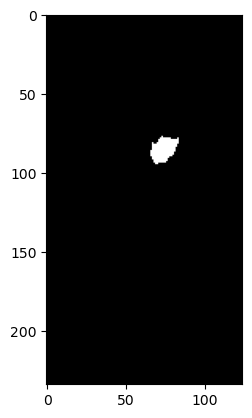

In [74]:
custom_cmap = plt.cm.colors.ListedColormap(['black', 'green', 'blue', 'red'])
plt.imshow(mri_data_flattened[160], cmap='gray')

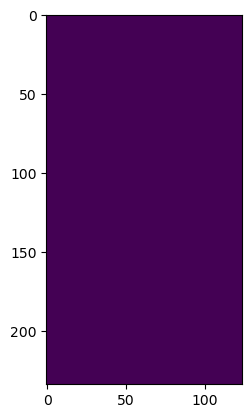

In [35]:
plt.imshow(mask_data[220])

In [29]:
modified_scan = nib.Nifti1Image(scaled_array, scan.affine)

# Save the modified scan as a new file (e.g., 'modified_mri_scan.nii.gz')
nib.save(modified_scan, 'threshold_data_20_512_2.nii.gz')


In [16]:
np.unique(clr)

array([0, 1, 2], dtype=int32)